In [ ]:
# # 구글 코랩용 뉴스 크롤링 + 워드클라우드 예제
# # 코랩에서는 대부분의 라이브러리가 이미 설치되어 있습니다

# # 워드클라우드 관련 라이브러리 설치 (코랩에서 한 번만 실행)
# !pip install wordcloud konlpy
# # 나눔고딕 폰트 설치 및 설정
# !apt-get update -qq
# !apt-get install fonts-nanum -qq
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 22.0 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/

In [ ]:




# 필요한 라이브러리 임포트
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 워드클라우드 관련 라이브러리
from wordcloud import WordCloud
from konlpy.tag import Okt, Kkma
from collections import Counter
import re

# 폰트 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# fontprop = fm.FontProperties(fname=font_path, size=10)
# plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False
font_path='/System/Library/Fonts/AppleGothic.ttf'

In [3]:


def crawl_naver_news():
    """네이버 뉴스 메인 페이지에서 헤드라인을 크롤링하는 함수"""

    print("📰 네이버 뉴스 크롤링을 시작합니다...")

    # 웹 페이지 URL
    url = "https://news.naver.com"

    # 헤더 설정 (코랩 환경에 맞게 조정)
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        # 웹 페이지 요청
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # HTML 파싱
        soup = BeautifulSoup(response.text, 'html.parser')

        # 뉴스 헤드라인 추출
        headlines = []

        # 여러 가지 방법으로 뉴스 헤드라인 찾기
        selectors = [
            'a.cjs_news_link',
            'a[href*="/article/"]',
            '.hdline_article_tit',
            '.cluster_text_headline'
        ]

        for selector in selectors:
            items = soup.select(selector)
            if items:
                for item in items[:15]:  # 더 많은 헤드라인 수집
                    title = item.get_text().strip()
                    if title and len(title) > 10:
                        headlines.append(title)
                break

        # 결과 출력
        print(f"\n 총 {len(headlines)}개의 뉴스 헤드라인을 찾았습니다!")
        print("=" * 60)

        for i, headline in enumerate(headlines[:10], 1):
            print(f"{i:2d}. {headline}")

        print("=" * 60)

        return headlines

    except requests.RequestException as e:
        print(f" 네트워크 오류: {e}")
        return []
    except Exception as e:
        print(f" 크롤링 오류: {e}")
        return []


In [ ]:

def preprocess_text_for_wordcloud(headlines):
    """워드클라우드를 위한 텍스트 전처리"""

    print(" 텍스트 전처리를 시작합니다...")

    # 모든 헤드라인을 하나의 텍스트로 결합
    full_text = ' '.join(headlines)

    # 불필요한 문자 제거
    # 특수문자, 숫자, 영어 등 제거 (한글만 남기기)
    cleaned_text = re.sub(r'[^가-힣\s]', '', full_text)

    # 형태소 분석기 초기화
    okt = Okt()

    # 명사만 추출
    nouns = okt.nouns(cleaned_text)

    # 불용어 리스트 (의미없는 단어들)
    stopwords = {
        '것', '등', '및', '이', '그', '저', '더', '또', '한', '두', '세', '네', '다섯',
        '있다', '없다', '되다', '하다', '이다', '아니다', '같다', '다르다',
        '때문', '위해', '통해', '대해', '관련', '따라', '의해', '에서', '에게', '으로', '로서',
        '기자', '뉴스', '보도', '취재', '인터뷰', '발표', '발언', '언론', '미디어',
        '오늘', '어제', '내일', '이번', '다음', '지난', '최근', '현재', '앞으로',
        '서울', '부산', '대구', '인천', '광주', '대전', '울산', '경기', '강원',
        '단독', '속보', '긴급', '특보', '화제', '이슈'
    }

    # 2글자 이상이고 불용어가 아닌 명사만 필터링
    filtered_nouns = [
        noun for noun in nouns
        if len(noun) >= 2 and noun not in stopwords
    ]

    # 단어 빈도 계산
    word_freq = Counter(filtered_nouns)

    print(f" 총 {len(word_freq)}개의 유의미한 단어를 추출했습니다.")
    print(f" 상위 10개 단어: {dict(word_freq.most_common(10))}")

    return word_freq

def create_wordcloud(word_freq, headlines_count):
    """워드클라우드 생성"""

    if not word_freq:
        print(" 워드클라우드를 생성할 단어가 없습니다.")
        return None

    print(" 워드클라우드를 생성합니다...")

    # 워드클라우드 설정
    wordcloud = WordCloud(
        # font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 코랩 한글 폰트
        font_path=font_path,  # macOS 한글 폰트
        width=1200,
        height=600,
        background_color='white',
        max_words=100,
        relative_scaling=0.3,
        colormap='viridis',
        random_state=42
    ).generate_from_frequencies(word_freq)

    # 워드클라우드 시각화
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f' Naver News Word Count (Total {headlines_count})',
              fontsize=16, fontweight='bold', pad=20)

    # 범례 추가
    plt.figtext(0.5, 0.02,
                f'생성시간: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                f'총 키워드: {len(word_freq)}개 | 데이터 출처: 네이버 뉴스',
                ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

    return wordcloud

def create_news_dataframe(headlines):
    """뉴스 헤드라인을 데이터프레임으로 변환"""

    if not headlines:
        print(" 분석할 헤드라인이 없습니다.")
        return None

    # 데이터프레임 생성
    df = pd.DataFrame({
        '순번': range(1, len(headlines) + 1),
        '헤드라인': headlines,
        '글자수': [len(headline) for headline in headlines],
        '크롤링시간': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * len(headlines)
    })

    print("\n 뉴스 데이터 분석:")
    print(f"총 뉴스 개수: {len(df)}")
    print(f"평균 글자수: {df['글자수'].mean():.1f}")
    print(f"최대 글자수: {df['글자수'].max()}")
    print(f"최소 글자수: {df['글자수'].min()}")

    return df


🚀 구글 코랩 뉴스 크롤링 + 워드클라우드 실습을 시작합니다!
📰 네이버 뉴스 크롤링을 시작합니다...

 총 15개의 뉴스 헤드라인을 찾았습니다!
 1. 李 대통령 국정지지율 59.7%… 민주 50.6%·국힘 30.0%



대전일보
 2. 1차 추경에도 내수 부진…산업생산 두 달째↓·소비 반등 못해



SBS
 3. 李대통령 국정수행 긍정평가 59.7%…민주 50.6%·국힘 30%



국제신문
 4. 李대통령 국정지지율 59.7%…정당 지지, 민주 50.6%·국힘 30.0%



강원일보
 5. 李대통령 국정지지율 59.7%…민주 50.6% vs 국힘 30.0%



한경비즈니스

내용작성전
 6. 5월 산업생산 1.1% 감소…소비보합·투자 뒷걸음



강원도민일보
 7. Lee Jae Myung picks 6 more ministers, 5 vice ministers, 2 senior aides
 8. 1 in 4 Koreans aged 20–50 invests in crypto
 9. Kospi heads for biggest first-half gain in 26 years
10. Telegram increases cooperation with Korean police in criminal investigations

 뉴스 데이터 분석:
총 뉴스 개수: 15
평균 글자수: 45.7
최대 글자수: 76
최소 글자수: 25

 데이터프레임 미리보기:
   순번                                               헤드라인  글자수  \
0   1   李 대통령 국정지지율 59.7%… 민주 50.6%·국힘 30.0%\n\n\n\n대전일보   44   
1   2       1차 추경에도 내수 부진…산업생산 두 달째↓·소비 반등 못해\n\n\n\nSBS   40   
2   3   李대통령 국정수행 긍정평가 59.7%…민주 50.6%·국힘 30%\n\n\n\n국제신문   44   
3   4  李대통령 국정지지율 59.7%…

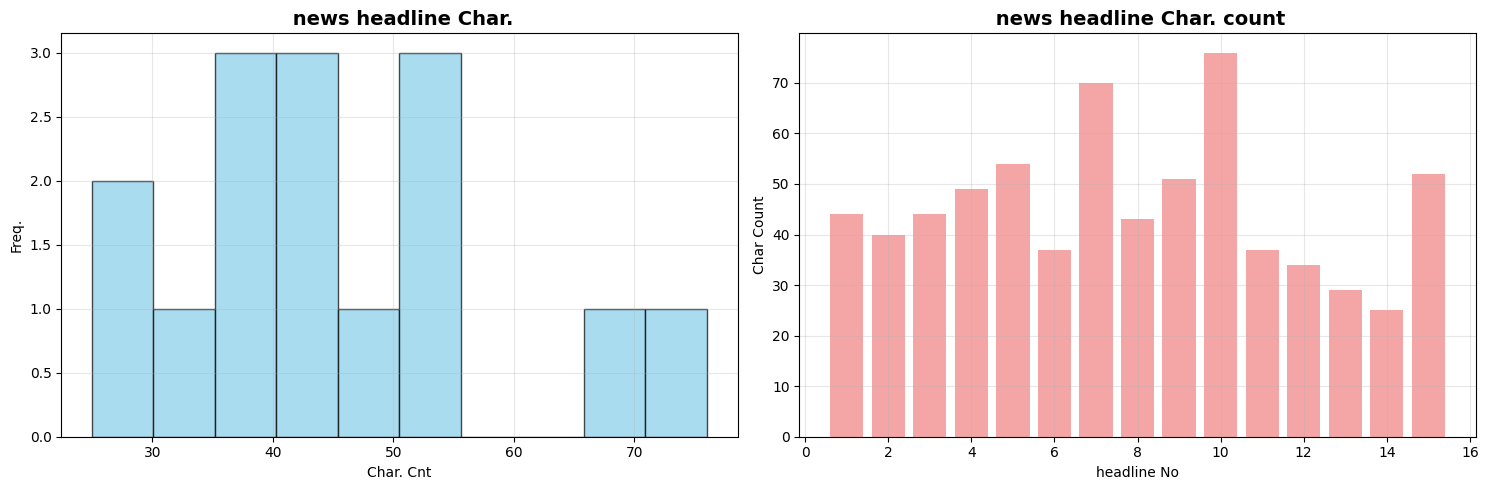

 텍스트 전처리를 시작합니다...
 총 56개의 유의미한 단어를 추출했습니다.
 상위 10개 단어: {'대통령': 5, '국정': 4, '민주': 4, '국힘': 4, '지지율': 3, '일보': 3, '산업': 2, '생산': 2, '소비': 2, '클라우드': 2}

 상위 20개 키워드:
 1. 대통령        (5회)
 2. 국정         (4회)
 3. 민주         (4회)
 4. 국힘         (4회)
 5. 지지율        (3회)
 6. 일보         (3회)
 7. 산업         (2회)
 8. 생산         (2회)
 9. 소비         (2회)
10. 클라우드       (2회)
11. 추경         (1회)
12. 부진         (1회)
13. 반등         (1회)
14. 수행         (1회)
15. 긍정         (1회)
16. 평가         (1회)
17. 국제         (1회)
18. 신문         (1회)
19. 정당         (1회)
20. 지지         (1회)
 워드클라우드를 생성합니다...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

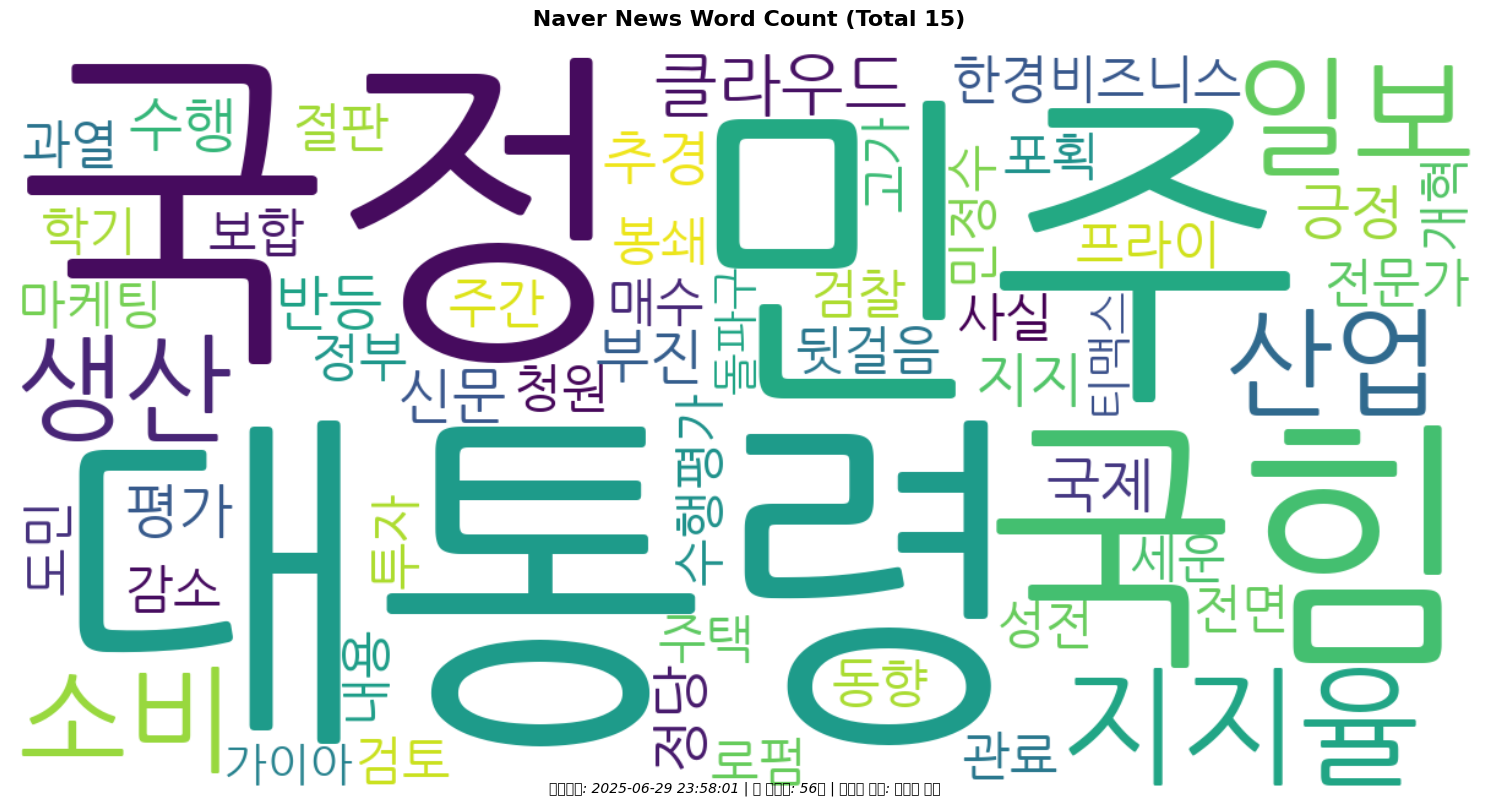


 'news_headlines_with_wordcloud.csv' 파일로 저장되었습니다!
 'keyword_frequency.csv' 파일로 키워드 빈도가 저장되었습니다!
   (코랩 왼쪽 파일 탭에서 다운로드 가능)
 'news_wordcloud.png' 파일로 워드클라우드가 저장되었습니다!

 뉴스 크롤링 + 워드클라우드 실습이 완료되었습니다!
🎉 수고하셨습니다!


In [5]:

def visualize_news_data(df):
    """뉴스 데이터 시각화"""

    if df is None or df.empty:
        print(" 시각화할 데이터가 없습니다.")
        return

    # 그래프 스타일 설정
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. 헤드라인 글자수 분포
    ax1.hist(df['글자수'], bins=10, color='skyblue', alpha=0.7, edgecolor='black')
    ax1.set_title(' news headline Char.', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Char. Cnt')
    ax1.set_ylabel('Freq.')
    ax1.grid(True, alpha=0.3)

    # 2. 헤드라인별 글자수
    ax2.bar(df['순번'], df['글자수'], color='lightcoral', alpha=0.7)
    ax2.set_title(' news headline Char. count', fontsize=14, fontweight='bold')
    ax2.set_xlabel('headline No')
    ax2.set_ylabel('Char Count')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def show_top_keywords(word_freq, top_n=20):
    """상위 키워드 표 형태로 출력"""

    if not word_freq:
        return

    print(f"\n 상위 {top_n}개 키워드:")
    print("=" * 40)

    for i, (word, count) in enumerate(word_freq.most_common(top_n), 1):
        print(f"{i:2d}. {word:<10} ({count}회)")

    print("=" * 40)

# 메인 실행 함수
def main():
    """메인 실행 함수"""

    print("🚀 구글 코랩 뉴스 크롤링 + 워드클라우드 실습을 시작합니다!")
    print("=" * 70)

    # 1. 네이버 뉴스 크롤링
    headlines = crawl_naver_news()

    if not headlines:
        print(" 크롤링된 뉴스가 없어 실습을 종료합니다.")
        return

    # 2. 데이터 분석
    df = create_news_dataframe(headlines)

    if df is not None:
        print("\n 데이터프레임 미리보기:")
        print(df.head())

        # 3. 기본 통계 시각화
        visualize_news_data(df)

    # 4. 워드클라우드를 위한 텍스트 전처리
    word_freq = preprocess_text_for_wordcloud(headlines)

    # 5. 상위 키워드 출력
    show_top_keywords(word_freq, top_n=20)

    # 6. 워드클라우드 생성
    wordcloud = create_wordcloud(word_freq, len(headlines))

    # 7. 파일 저장
    if df is not None:
        # CSV 파일로 저장
        df.to_csv('news_headlines_with_wordcloud.csv', index=False, encoding='utf-8')
        print("\n 'news_headlines_with_wordcloud.csv' 파일로 저장되었습니다!")

        # 키워드 빈도 CSV로 저장
        keyword_df = pd.DataFrame(word_freq.most_common(), columns=['키워드', '빈도'])
        keyword_df.to_csv('keyword_frequency.csv', index=False, encoding='utf-8')
        print(" 'keyword_frequency.csv' 파일로 키워드 빈도가 저장되었습니다!")

        print("   (코랩 왼쪽 파일 탭에서 다운로드 가능)")

    # 8. 워드클라우드 이미지 저장
    if wordcloud:
        wordcloud.to_file('news_wordcloud.png')
        print(" 'news_wordcloud.png' 파일로 워드클라우드가 저장되었습니다!")


# 개별 실행 함수들
def run_wordcloud_only():
    """워드클라우드만 생성하는 함수"""
    headlines = crawl_naver_news()
    if headlines:
        word_freq = preprocess_text_for_wordcloud(headlines)
        show_top_keywords(word_freq)
        create_wordcloud(word_freq, len(headlines))

def run_analysis_only():
    """기본 분석만 실행하는 함수"""
    headlines = crawl_naver_news()
    if headlines:
        df = create_news_dataframe(headlines)
        if df is not None:
            print(df)
            visualize_news_data(df)

# 코랩에서 바로 실행
if __name__ == "__main__":
    # 전체 실행
    main()

    # 또는 개별 실행
    # run_wordcloud_only()  # 워드클라우드만
    # run_analysis_only()   # 기본 분석만